In [5]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [6]:
#Divede the train, validation and test dataset.
file_handler = open("../pairsDevTrain.txt", "r", encoding="utf-8")

# We must first put the data in a list
train_same = [];
train_diff= [];

for row in file_handler:
    # The values we read are strings, we must convert them to the correct type (float)
    temp=row.replace("\n", "");
    string= temp.split("\t") # split it by whitespace
    converted = [x for x in string]
    if len(converted) ==3:
        #train_same.append( [converted[0],converted[1],converted[0],converted[2] ]);
        train_same.append( converted );
    if len(converted) ==4:
        train_diff.append(converted);
file_handler.close()


file_handler = open("../pairsDevTest.txt", "r", encoding="utf-8")
# We must first put the data in a list
test_same = [];
test_diff= [];

for row in file_handler:
    temp=row.replace("\n", "");
    string= temp.split("\t") # split it by whitespace
    converted = [x for x in string]
    if len(converted) ==3:
        test_same.append( converted );
    if len(converted) ==4:
        test_diff.append(converted);
file_handler.close()

print("There are {} images in the train, {} in the test".format(len(train_same)+ len(train_diff), len(test_same)+ len(test_diff) ) );


vali_same= train_same[0: 250: 1];
vali_diff= train_diff[0: 250: 1];

train_same=train_same[250: : 1]
train_diff=train_diff[250: : 1]

There are 2200 images in the train, 1000 in the test


In [7]:
len( train_same), len(train_diff), len(vali_same), len(vali_diff), len(test_same), len(test_diff)

(850, 850, 250, 250, 500, 500)

In [10]:
width, height, channels=96, 96, 3
def format_filename(name, number):
    num_zeros = "0"*(4 - len(number))
    filepath = "../lfw-deepfunneled/"+name+"/"+name+"_"+num_zeros+number+".jpg"
    return filepath


def extractFaceCo (imagePath): 
    cascPath = "haarcascade_frontalface_default.xml"
    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    # Read the image
    image = cv2.imread(imagePath ) #read a RGB image
    #print(image.shape)
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    #flags = cv2.CV_HAAR_SCALE_IMAGE
    )
     
    # Draw a rectangle around the faces
    if len(faces)==0:  #no face is detected
        print(imagePath)
        return np.array([])
    
    best_x, best_y, best_w, best_h=0,0,250,250;
    best_size= -np.float("inf")
    for (x, y, w, h) in faces: #There might be more than one face
        if w*h> best_size:
            best_size= w*h
            best_x, best_y, best_w, best_h= x, y, w, h
    
    
    image1= image[ best_y:best_y+best_h, best_x:best_x+best_w ]
    face= cv2.resize(image1, (width, height), interpolation = cv2.INTER_AREA)
    
    #print(face.shape)
    #print(face[0, 0:5])
    return face #is returning a local variable legal? 


def get_batch(batch_size, same, diff):
    # initialize 2 empty arrays for the input image batch

    pairs=[np.zeros( (batch_size, height, width, channels) ) for i in range(2)]    
    # initialize vector for the targets
    targets=np.zeros( batch_size )
    
    num_fails=0;
    not_enough=0
    for i in range( batch_size//2 ):
        
        img1= extractFaceCo(format_filename( same[i][0], same[i][1] )  )
        img2= extractFaceCo(format_filename( same[i][0], same[i][2] )  )        
        while (len(img1)==0 or len(img2)==0): #fails to detect the face
            num_fails+=1
            if (i+ num_fails >= len(same) ):
                print("Did not find enough qualified images, please reduce the batch_size")
                not_enough=1;
                break;
            
            img1= extractFaceCo(format_filename( same[-num_fails][0], same[-num_fails][1] )  )
            img2= extractFaceCo(format_filename( same[-num_fails][0], same[-num_fails][2] )  )
        
        if not_enough:
            break;
        pairs[0][i, :, :, :]= img1.reshape(height, width, -1)
        pairs[1][i, :, :, :]= img2.reshape(height, width, -1)   
        targets[i]= 1;
        
        #print to check whether it is correct
        #print("now in get_batch")
        #print(img1[0, 0:5])
        #print( pairs[0][i, 0, 0:5, 0])
        
    num_fails-= num_fails;  
    not_enough=0
    for i in range( batch_size//2, batch_size ):
        j= i- batch_size//2; #j start from 0
        img1= extractFaceCo(format_filename( diff[j][0], diff[j][1] )  )
        img2= extractFaceCo(format_filename( diff[j][2], diff[j][3] )  )
            
        while (len(img1)==0 or len(img2)==0): #fails to detect the face
            num_fails+=1
            if (j+ num_fails >= len(diff) ): #i+num_fails== len(diff): they are pointing to the same element.
                print("Did not find enough qualified images, please reduce the batch_size")
                not_enough=1;
                break;
            img1= extractFaceCo(format_filename( diff[-num_fails][0], diff[-num_fails][1] )  )
            img2= extractFaceCo(format_filename( diff[-num_fails][2], diff[-num_fails][3] )  )
        
        if not_enough:
            break;    
        pairs[0][i, :, :, :]= img1
        pairs[1][i, :, :, :]= img2
        targets[i]= 0;  
        
        #print to check whether it is correct
        #print("now in get_batch")
        #print(img2[0, 0:5])
        #print( pairs[1][i, 0, 0:5, 0])
    return pairs, targets

def fillIdent(batch_size, same, diff):       
    name={}
    ident_in=[];
    indet_out=[];
    ident_y=[]
    
    i=0    
    num_fails=0;
    num_same=0;
    not_enough=0
    while num_same< batch_size//2 and i< len(same):
        if same[i][0] in name:
            i+=1
            continue
        name[ same[i][0] ]=1;   
        img1= extractFaceCo(format_filename( same[i][0], same[i][1] )  )
        img2= extractFaceCo(format_filename( same[i][0], same[i][2] )  )        
        while (len(img1)==0 or len(img2)==0): #fails to detect the face
            num_fails+=1
            if (i+ num_fails >= len(same) ):
                print("Did not find enough qualified images, please reduce the batch_size")
                not_enough=1
                break;
            
            img1= extractFaceCo(format_filename( same[-num_fails][0], same[-num_fails][1] )  )
            img2= extractFaceCo(format_filename( same[-num_fails][0], same[-num_fails][2] )  )
            
        if not_enough:
            break;
        num_same+=1    
        ident_in.append( img1.reshape(height, width, -1) )
        ident_out.append( img2.reshape(height, width, -1)  )
        ident_y.append(1);
        
    i=0    
    num_fails=0;
    num_diff=0
    not_enough=0
    while num_same+ num_diff< batch_size and i< len(diff):
        if diff[i][0] in name:
            i+=1
            continue
        name[ diff[i][0] ]=1
            
        img1= extractFaceCo(format_filename( diff[i][0], diff[i][1] )  )
        img2= extractFaceCo(format_filename( diff[i][2], diff[i][3] )  )      
        while (len(img1)==0 or len(img2)==0): #fails to detect the face
            num_fails+=1
            if (i+ num_fails >= len(same) ):
                print("Did not find enough qualified images, please reduce the batch_size")
                not_enough=1;
                break;
            
            img1= extractFaceCo(format_filename( diff[-num_fails][0], diff[-num_fails][1] )  )
            img2= extractFaceCo(format_filename( diff[-num_fails][2], diff[-num_fails][3] )  )
            
        if not_enough:
            break;
        num_diff+=1;
        ident_in.append( img1.reshape(height, width, -1) )
        ident_out.append( img2.reshape(height, width, -1)  )
        ident_y.append(0);
    return ident_in, ident_out, ident_y
        
        
        
        


In [9]:
train_X, train_y= get_batch(1000, train_same, train_diff);
print("start to work on validation")
vali_X, vali_y= get_batch(200, vali_same, vali_diff);
print("start to work on test")
test_X, test_y= get_batch(20, test_same, test_diff);

../lfw-deepfunneled/George_P_Bush/George_P_Bush_0001.jpg
../lfw-deepfunneled/Juan_Pablo_Montoya/Juan_Pablo_Montoya_0005.jpg
../lfw-deepfunneled/Kate_Capshaw/Kate_Capshaw_0002.jpg
../lfw-deepfunneled/Ken_Watanabe/Ken_Watanabe_0001.jpg
../lfw-deepfunneled/Kobe_Bryant/Kobe_Bryant_0001.jpg
../lfw-deepfunneled/Budd_Schulberg/Budd_Schulberg_0001.jpg
../lfw-deepfunneled/Keith_Brown/Keith_Brown_0001.jpg
../lfw-deepfunneled/Clive_Lloyd/Clive_Lloyd_0001.jpg
../lfw-deepfunneled/Roy_Halladay/Roy_Halladay_0001.jpg
../lfw-deepfunneled/Hernan_Diaz/Hernan_Diaz_0001.jpg
../lfw-deepfunneled/Dereck_Whittenburg/Dereck_Whittenburg_0001.jpg
../lfw-deepfunneled/Julio_Rossi/Julio_Rossi_0001.jpg
../lfw-deepfunneled/Mickey_Rooney/Mickey_Rooney_0001.jpg
../lfw-deepfunneled/Irwan_Fadzi_Idris/Irwan_Fadzi_Idris_0001.jpg
../lfw-deepfunneled/Irwan_Fadzi_Idris/Irwan_Fadzi_Idris_0001.jpg
../lfw-deepfunneled/Pele/Pele_0001.jpg
../lfw-deepfunneled/Shingo_Katayama/Shingo_Katayama_0001.jpg
start to work on validation
start

In [12]:
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = K.sum( K.square( anchor- positive ), axis= -1 )
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = K.sum( K.square( anchor- negative ), axis= -1 )
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss =  pos_dist- neg_dist+ alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = K.sum( K.maximum( basic_loss, 0.0 ) )
    ### END CODE HERE ###    
    return loss

FRmodel = faceRecoModel( [3, 96, 96] )
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [13]:
#use abs of different
EPSILON=0.0001
class FaceVerification:
    def __init__(self):
        
        self.encoding=[]
        self.same_person=[]
        self.score=0
        self.encoding_vali=[]
        
        self.data_base= {}
        
        
    def encodingImages(self, X, y): #list of 2 4 dimension array [batch, h, w, channels]
        self.encoding.clear()
        self.same_person.clear()
        for i in range( len( y ) ): #X[0] and X[1] form image pairs
            img1= X[0][i, :, :, :]  #(height, width, channel)
            img2= X[1][i, :, :, :]  #(height, width, channel)
            #encoding1= img_to_encoding( img1, FRmodel ).ravel()
            #encoding2= img_to_encoding( img2, FRmodel).ravel()
            #diff= (encoding1- encoding2)**2/ max(encoding1+ encoding2, EPSILON)
            
            
            diff= np.abs( img_to_encoding( img1, FRmodel ).ravel()- img_to_encoding( img2, FRmodel).ravel() )
            self.encoding.append( diff )  #list of 1d array
            self.same_person.append( y[i] )  #list of numbers 
            
    def encodingVali(self, X):
        self.encoding_vali.clear()
        for i in range( len( X[0] ) ): #X[0] and X[1] form image pairs
            img1= X[0][i, :, :, :]  #(height, width, channel)
            img2= X[1][i, :, :, :]  #(height, width, channel)
            #encoding1= img_to_encoding( img1, FRmodel ).ravel()
            #encoding2= img_to_encoding( img2, FRmodel).ravel()
            #diff= (encoding1- encoding2)**2/ max(encoding1+ encoding2, EPSILON) #Chi^2 distance
            diff= np.abs( img_to_encoding( img1, FRmodel  ).ravel()- img_to_encoding( img2, FRmodel  ).ravel() )
            self.encoding_vali.append( diff )  #list of 1d array
        
    
    def trainModelPredict(self, C): #Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
        model= LogisticRegression(penalty="l2", dual=False, tol=0.0001, solver='lbfgs', C=C )
        scores=cross_val_score(model, self.encoding, self.same_person, scoring="accuracy", cv = 5)
        self.score= scores.mean();
        
        model.fit(self.encoding, self.same_person)
        
        predicts=model.predict( self.encoding_vali)
        return predicts, self.score
            

In [124]:
#use Chi^2 distance (x-y)^2/(x+y)
EPSILON=0.0001
class FaceVerification:
    def __init__(self):
        
        self.encoding=[]
        self.same_person=[]
        self.score=0
        self.encoding_vali=[]
        
        self.model=LogisticRegression(penalty="l2", dual=False, tol=0.0001, solver='lbfgs')
        
        self.data_base= {}
        
        
    def encodingImages(self, X, y): #list of 2 4 dimension array [batch, h, w, channels]
        self.encoding.clear()
        self.same_person.clear()
        for i in range( len( y ) ): #X[0] and X[1] form image pairs
            img1= X[0][i, :, :, :]  #(height, width, channel)
            img2= X[1][i, :, :, :]  #(height, width, channel)
            #encoding1= img_to_encoding( img1, FRmodel ).ravel()
            #encoding2= img_to_encoding( img2, FRmodel).ravel()
            #diff= (encoding1- encoding2)**2/ max(encoding1+ encoding2, EPSILON)
            
            
            diff= np.abs( img_to_encoding( img1, FRmodel ).ravel()- img_to_encoding( img2, FRmodel).ravel() )
            self.encoding.append( diff )  #list of 1d array
            self.same_person.append( y[i] )  #list of numbers 
            
    def encodingVali(self, X):
        self.encoding_vali.clear()
        for i in range( len( X[0] ) ): #X[0] and X[1] both are 3d arrays [batch, height, width, channels]
            img1= X[0][i, :, :, :]  #(height, width, channel)
            img2= X[1][i, :, :, :]  #(height, width, channel)
            #encoding1= img_to_encoding( img1, FRmodel ).ravel()
            #encoding2= img_to_encoding( img2, FRmodel).ravel()
            #diff= (encoding1- encoding2)**2/ max(encoding1+ encoding2, EPSILON) #Chi^2 distance
            diff= np.abs( img_to_encoding( img1, FRmodel  ).ravel()- img_to_encoding( img2, FRmodel  ).ravel() )
            self.encoding_vali.append( diff )  #list of 1d array
        
    
    def trainModelPredict(self, C): #Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
        self.model= LogisticRegression(penalty="l2", dual=False, tol=0.0001, solver='lbfgs', C=C )
        scores=cross_val_score(self.model, self.encoding, self.same_person, scoring="accuracy", cv = 5)
        self.score= scores.mean();
        
        self.model.fit(self.encoding, self.same_person)
        
        predicts=self.model.predict( self.encoding_vali)
        return predicts, self.score
    
    def buildDataBase(self, X, names): #X is a list of 3d arrays [height, width, channels]
        self.data_base.clear()
        for i in range( len( names ) ): #X[0] and X[1] form image pairs
            img= X[i]  #(height, width, channel)
            encoding= img_to_encoding( img, FRmodel  ).ravel()
            self.data_base[ names[i] ]= encoding   #list of 1d array
            
    def verify(self, X): #X is a list of 3d arrays [height, width, channels]
        wheIn=[];
        for i in range( len( X ) ): #X[0] and X[1] form image pairs
            img= X[i]  #(height, width, channel)
            encoding= img_to_encoding( img, FRmodel  ).ravel()
            
            for encoding_DB in self.data_base.values(): #compare this encoding with encodings in DB
                diff= np.abs( encoding- encoding_DB )   #id array (128, )
                if self.model.predict( [diff] )== 1:  #input list of 1 d array
                    wheIn.append(True); # this people is in the database
                    break;
            else:
                wheIn.append(False) #this person is not in the database.
        return wheIn
 

In [125]:
face_veri=FaceVerification();
face_veri.encodingImages( train_X, train_y )
face_veri.encodingVali(vali_X);

In [126]:
scores=[ ]
for C in [0.01, 0.03, 0.1, 0.3,  1, 3, 10]:
    predicts, score= face_veri.trainModelPredict(C)  
    scores.append(score)
predictions, score= face_veri.trainModelPredict(3)

In [127]:
TN=sum( (vali_y== predictions)& (vali_y==0)  )/sum((vali_y==0))
TP=sum( (vali_y== predictions)& (vali_y==1)  )/sum((vali_y==1))
print(TP, TN, (TP+TN)/2 )

0.75 0.75 0.75


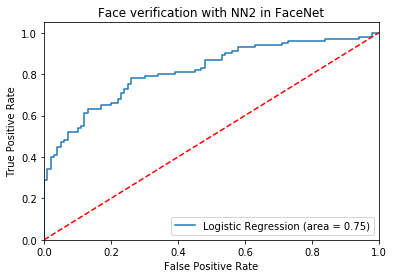

In [67]:
#Plot the ROC curve
logreg= LogisticRegression(penalty="l2", dual=False, tol=0.0001, solver='lbfgs', C=3 )
logreg.fit(face_veri.encoding, face_veri.same_person)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(vali_y, logreg.predict(face_veri.encoding_vali) )
fpr, tpr, thresholds = roc_curve(vali_y, logreg.predict_proba(face_veri.encoding_vali)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Face verification with NN2 in FaceNet')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.savefig("../figures/NN2_AUC_T1000.png", dpi=500)
plt.show()

In [86]:
#Face idnetification
#step1. Calculate the count of persons in test_same, test_diff;
#step2. pick up the 2 persons with the most images to data base.
#step3. pick up 20 images for each of the two persons and 40 images of others form a verification set.
#step4. predict whether a person is in or not
same_set= test_same
diff_set= test_diff

names_test={}
for i in range( len(same_set) ): 
    if same_set[i][0] not in names_test:
        names_test[ same_set[i][0] ]= set( [ same_set[i][1], same_set[i][2] ])
    else:
        names_test[ same_set[i][0]].add(same_set[i][1] )
        names_test[same_set[i][0]].add(same_set[i][2] )
    
for i in range( len(diff_set)): 
    if diff_set[i][0] not in names_test:
        names_test[ diff_set[i][0] ]= set( [ diff_set[i][1]] )
    else:
        names_test[diff_set[i][0]].add(diff_set[i][1] )
    
    if diff_set[i][2] not in names_test:
        names_test[ diff_set[i][2] ]= set( [ diff_set[i][3]] )
    else:
        names_test[ diff_set[i][2] ].add(diff_set[i][3] )   

In [87]:
def map_key(x):
    return -len( x[1] )

top_names= sorted( names_test.items(), key=map_key)[0: 2]

In [116]:
names_DB=["George_W_Bush", "Tony_Blair"]
images_DB=[];
for name in names_DB:
    i=2;
    while True:
        img= extractFaceCo( format_filename( name, str(i) )  )
        if len(img)==0:
            i+=1;
        else:
            images_DB.append( img)
            break;  
ident_X=[];
ident_y=[];

for name in names_DB:
    i, num_images=3, 0
    while num_images< 25 and i<=236:
        img= extractFaceCo( format_filename( name, str(i) )  )
        if len(img)==0:
            i+=1;
        else:
            ident_X.append( img)
            ident_y.append(True)
            i+=1
            num_images+=1
            
num_images=0;            
for name in names_test.keys():
    if num_images>= 50:
        break;
        
    for num in names_test[name]:
        img= extractFaceCo( format_filename( name, num )  )
        if len(img)==0:
            continue
        else:
            num_images+=1;
            ident_X.append( img )
            ident_y.append( False )
            break; 

In [128]:
face_veri.buildDataBase(images_DB, names_DB)

In [129]:
ident_pre=face_veri.verify( ident_X)

In [137]:
ident_y, ident_pre= np.array(ident_y), np.array(ident_pre)
TN=sum( (ident_y== ident_pre)& (ident_y==False)  )/sum((ident_y==False))
TP=sum( (ident_y== ident_pre)& (ident_y==True)  )/sum((ident_y==True))
accuracy= sum(ident_y== ident_pre)/ len(ident_y)
print(TP, TN, accuracy )

0.9 0.52 0.71
